# 2.morphogenesis vector fields and trajectories

## Packages

In [1]:
import os
import sys

import numpy as np
import dynamo as dyn
import spateo as st

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: Future

## Data source

In [ ]:
# stage1: E7-9h
stage1_adata = st.sample_data.drosophila(filename="E7-9h_cellbin_tdr_v2_midgut.h5ad")
stage1_adata = stage1_adata[:, np.sum(stage1_adata.layers["counts_X"], axis=0) != 0]
stage1_adata.uns["pp"] = {}
stage1_adata.X = stage1_adata.layers["counts_X"].copy()
dyn.pp.normalize_cell_expr_by_size_factors(adata=stage1_adata, layers="X", X_total_layers=True)

# stage2: E9-10h
stage2_adata = st.sample_data.drosophila(filename="E9-10h_cellbin_tdr_v2_midgut.h5ad")
stage2_adata = stage1_adata[:, np.sum(stage2_adata.layers["counts_X"], axis=0) != 0]
stage2_adata.uns["pp"] = {}
stage2_adata.X = stage2_adata.layers["counts_X"].copy()
dyn.pp.normalize_cell_expr_by_size_factors(adata=stage2_adata, layers="X", X_total_layers=True)
tissue_adatas = [stage1_adata, stage2_adata]

## Alignment of models from two stages based on gene expression information(primarily)

In [3]:
st.tdr.cell_directions(
    adatas=tissue_adatas,
    numItermaxEmd=500000,
    # layer="log1p_X",
    spatial_key="3d_align_spatial",
    key_added="cells_mapping",
    alpha=0.0001,
    device="0",
    inplace=True
)
mapping_stage1_adata = tissue_adatas[0].copy()
mapping_stage2_adata = tissue_adatas[1].copy()
tissue_adatas

|-----> [Cell Directions] in progress: 100.0000%|-----------> Filtered all samples for common genes. There are 7381 common genes.
|-----> [Cell Directions] in progress: 100.0000%
|-----> [Cell Directions] finished [47.0444s]


[AnnData object with n_obs × n_vars = 2326 × 7685
     obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'Size_Factor', 'initial_cell_size'
     uns: 'PCs', '__type', 'auto_anno_result', 'dendrogram_anno_cell_type', 'dendrogram_anno_germ_layer', 'dendrogram_anno_tissue', 'explained_variance_ratio_', 'latter_models_align', 'neighbors', 'pca_mean', 'pca_valid_ind', 'pearson_X_neighbors', 'rank_genes_groups', 'rank_genes_groups_anno_cell_type', 'rank_genes_groups_anno_germ_layer', 'rank_genes_groups_anno_tissue', 'scc', 'spatial', 'pp'
     obsm: '3d_align_spatial', 'align_spatial', 'bbox', 'before_3d_align_spatial', 'contour', 'pearson_X_pca', 'pearson_X_umap', 'spatial', 'tdr_spatial', 'X_cells_mapping', 'V_cells_mapping'
     layers: 'counts_X', 'log1p_X', 'pearson_X', 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 3073 × 7969
     obs: 'area', 'slices

## Generate and check aligned models

### Generate aligned point cloud models and mesh models

In [4]:
stage1_aligned_pc = st.tdr.construct_pc(
    adata=mapping_stage1_adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap={"midgut": "#DC143C"},
)
stage1_aligned_mesh, _ = st.tdr.construct_surface(
    pc=stage1_aligned_pc,
    key_added="tissue",
    label="midgut",
    color="#DC143C",
    cs_method="marching_cube",
    cs_args={"mc_scale_factor": 0.6},
    smooth=5000,
)

stage2_aligned_pc = st.tdr.construct_pc(
    adata=mapping_stage2_adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap={"midgut": "#DC143C"},
)
stage2_aligned_mesh, _ = st.tdr.construct_surface(
    pc=stage2_aligned_pc,
    key_added="tissue",
    label="midgut",
    color="#DC143C",
    cs_method="marching_cube",
    cs_args={"mc_scale_factor": 0.9},
    smooth=5000,
)

### Check the mapping result between the aligned models

In [6]:
align_lines = st.tdr.construct_align_lines(
    model1_points=mapping_stage1_adata.obsm["3d_align_spatial"].copy(),
    model2_points=mapping_stage1_adata.obsm["X_cells_mapping"].copy() + np.asarray([0, 0, -300]),
    key_added="check_align", label="align_lines", color="gainsboro")

stage1_aligned_pc_v = stage1_aligned_pc.copy()
stage2_aligned_pc_v = stage2_aligned_pc.copy()
stage2_aligned_pc_v.points[:, 2] = stage2_aligned_pc_v.points[:, 2] - 300

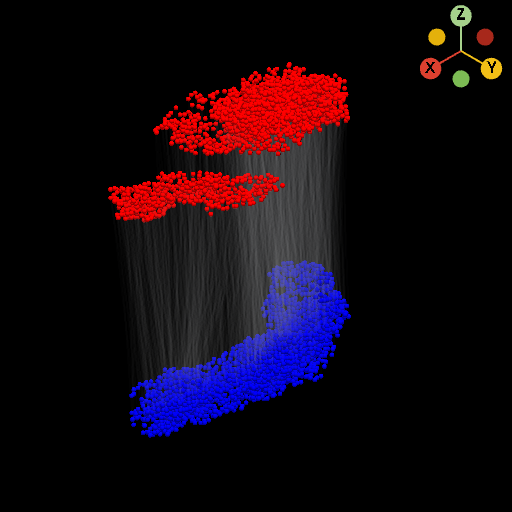

In [16]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([align_lines, stage1_aligned_pc_v, stage2_aligned_pc_v]),
    colormap=["gainsboro", "red", "blue"],
    opacity=[0.01, 1.0, 1.0],
    model_style=["wireframe", "points", "points"],
    model_size=[2, 5, 5],
    show_legend=False,
    off_screen=False,
    jupyter="static",
    background="black",
    window_size=(512, 512),
    cpo="iso"
)

## Calculate the developmental Vectorfield

In [12]:
st.tdr.morphofield(
    adata=mapping_stage1_adata,
    spatial_key="3d_align_spatial",
    V_key="V_cells_mapping",
    key_added="VecFld_morpho",
    NX=np.asarray(stage1_aligned_mesh.points),
    inplace=True,
)
stage1_aligned_pc.point_data["vectors"] = mapping_stage1_adata.uns["VecFld_morpho"]["V"]
stage1_aligned_mesh.point_data["vectors"] = mapping_stage1_adata.uns["VecFld_morpho"]["grid_V"]

|-----? The length of [  0 100 200 300 400] is different from 10, using `np.range(restart_num) * 100
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.3665s]
|-----> [morphofield] in progress: 100.0000%
|-----> [morphofield] finished [334.0710s]


In [20]:
cpo = [(553.2878243418567 / 2, 1098.4674808068507 / 2, 277.4399476053088/ 2),
 (1.9670869138005287, -6.902875264241757, -2.2120172004343885),
 (-0.16299443079060863, -0.16480753930466982, 0.9727647662819544)]

|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


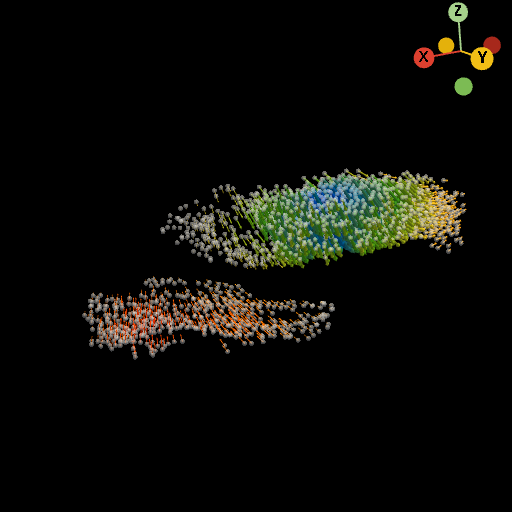

In [28]:
vector_arrows1 = st.tdr.construct_field(
    model=stage1_aligned_pc,
    vf_key="vectors",
    arrows_scale_key="vectors",
    n_sampling=None,
    factor=3000,
    key_added="v_arrows",
    label=stage1_aligned_pc.point_data["vectors"][:, 2].flatten(),
    color= "rainbow",
)

st.pl.three_d_plot(
    model=st.tdr.collect_models([stage1_aligned_pc, vector_arrows1]),
    key=["tissue", "v_arrows"],
    colormap=["gainsboro", "rainbow"],
    opacity=[0.5, 1],
    model_style=["points", "surface"],
    model_size=5,
    show_legend=False,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=False,
    jupyter="static",
    background="black",
    window_size=(512, 512),
    cpo=cpo,
)

In [23]:
vector_arrows2 = st.tdr.construct_field(
    model=stage1_aligned_mesh,
    vf_key="vectors",
    arrows_scale_key="vectors",
    n_sampling=1500,
    sampling_method="trn",
    factor=3000,
    key_added="v_arrows",
    label=stage1_aligned_mesh.point_data["vectors"][:, 2].flatten(),
)

|-----> [Running TRN] in progress: 100.0000%
|-----> [Running TRN] finished [213.4013s]


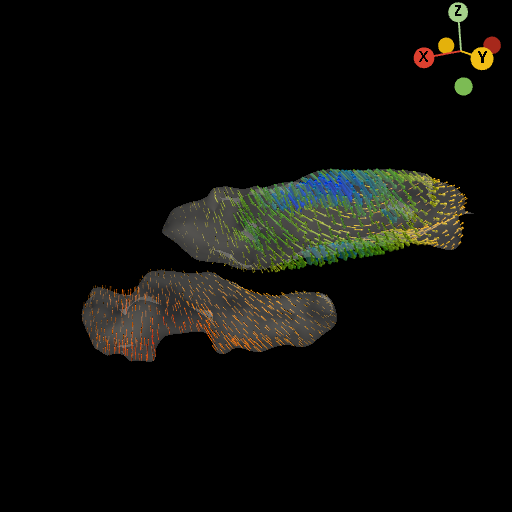

In [24]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([stage1_aligned_mesh, vector_arrows2]),
    key=["tissue", "v_arrows"],
    opacity=[0.2, 1],
    colormap=["gainsboro", "rainbow"],
    model_style="surface",
    show_legend=False,
    off_screen=False,
    jupyter="static",
    background="black",
    window_size=(512, 512),
    cpo=cpo,
)

## Predict the cell developmentalal trajectory

In [25]:
st.tdr.morphopath(
    adata=mapping_stage1_adata,
    # layer="log1p_X",
    vf_key="VecFld_morpho",
    key_added="fate_morpho",
    t_end=20000,
    interpolation_num=50,
    cores=20
)
trajectory_model = st.tdr.construct_trajectory(
    adata=mapping_stage1_adata,
    fate_key="fate_morpho",
    n_sampling=500,
    sampling_method="trn",
    label=mapping_stage1_adata.uns["VecFld_morpho"]["V"][:, 2].flatten(),
    trajectory_color="rainbow",
    tip_color="rainbow",
)

|-----> [Running TRN] in progress: 100.0000%
|-----> [Running TRN] finished [23.9479s]


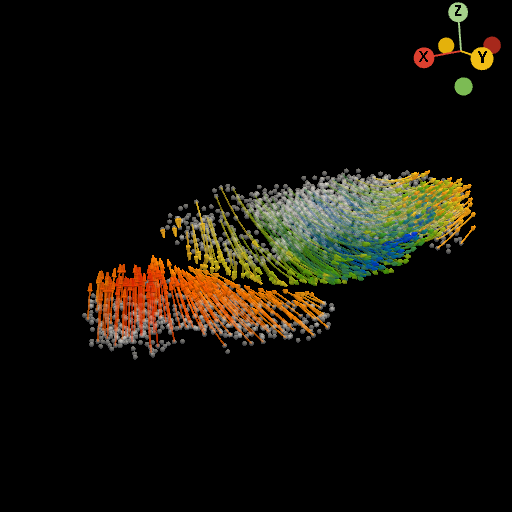

In [26]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([stage1_aligned_pc, trajectory_model]),
    key=["tissue", "trajectory"],
    opacity=[0.5, .5],
    model_style=["points", "wireframe"],
    model_size=[5, 2],
    colormap=["gainsboro", "rainbow"],
    show_legend=False,
    off_screen=False,
    jupyter="static",
    background="black",
    window_size=(512, 512),
    cpo=cpo,
)

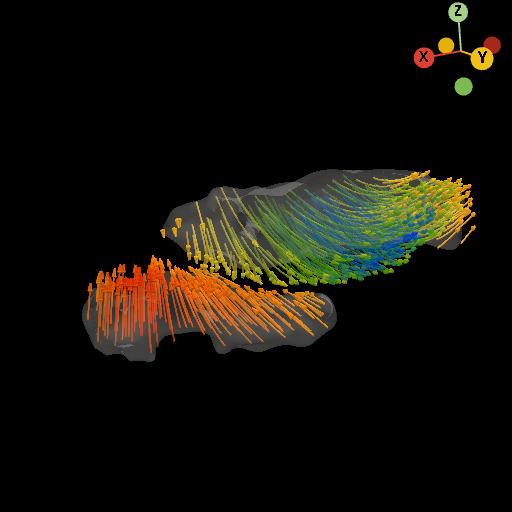

In [27]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([stage1_aligned_mesh, trajectory_model]),
    key=["tissue", "trajectory"],
    opacity=[0.2, .5],
    model_style=["surface", "wireframe"],
    model_size=2,
    colormap=["gainsboro", "rainbow"],
    show_legend=False,
    off_screen=False,
    jupyter="static",
    background="black",
    window_size=(512, 512),
    cpo=cpo,
)

## Animating cell fate prediction

In [19]:
cells_models = st.tdr.construct_genesis(
    adata=mapping_stage1_adata,
    fate_key="fate_morpho",
    n_steps = 100,
    logspace=True,
    t_end=1000,
    label=[mapping_stage1_adata.uns["VecFld_morpho"]["V"][:, 2]] * 100,
    color="rainbow"
)
st.pl.three_d_animate(
    models=cells_models,
    stable_model=trajectory_model,
    key="genesis",
    stable_kwargs=dict(
        key="trajectory",
        model_style="wireframe",
        model_size=2,
        opacity=0.3,
        colormap="rainbow",
        show_legend=False,
    ),
    filename=f"develop_Midgut_model_trajectory.mp4",
    colormap="rainbow",
    model_style="points",
    model_size=5,
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=False,
    jupyter="static",
    background="black",
    window_size=(1024, 1024),
    cpo=cpo,
    framerate=10
)

In [20]:
cells_linear_models = st.tdr.construct_genesis_X(
    stages_X=[mapping_stage1_adata.obsm["3d_align_spatial"], mapping_stage1_adata.obsm["X_cells_mapping"]],
    n_spacing=100,
    key_added="genesis",
    label=[mapping_stage1_adata.uns["VecFld_morpho"]["V"][:, 2]] * (100 + 1),
)
st.pl.three_d_animate(
    models=cells_linear_models,
    stable_model=trajectory_model,
    key="genesis",
    stable_kwargs=dict(
        key="trajectory",
        model_style="wireframe",
        model_size=2,
        opacity=0.3,
        colormap="rainbow",
        show_legend=False,
    ),
    filename=f"develop_Midgut_model_trajectory_linear.mp4",
    model_style="points",
    model_size=5,
    colormap="rainbow",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=False,
    jupyter="static",
    background="black",
    window_size=(1024, 1024),
    cpo=cpo,
    framerate=10)